[nltk_data] Downloading package punkt to /home/mohmmad/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/home/mohmmad/.local/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 0, Step 0, Loss 1.049381971359253
Epoch 0, Step 10, Loss 0.7185387015342712
Epoch 0 - Average Loss: 0.9637172487046983
Epoch 1, Step 0, Loss 1.233371615409851
Epoch 1, Step 10, Loss 0.9678156971931458
Epoch 1 - Average Loss: 0.9470347464084625
Epoch 2, Step 0, Loss 0.9364068508148193
Epoch 2, Step 10, Loss 0.9974403381347656
Epoch 2 - Average Loss: 0.9451495276557075
Weighted F1 Score: 0.569216757741348
Accuracy: 0.6944444444444444
Precision: 0.48225308641975306
Recall: 0.6944444444444444


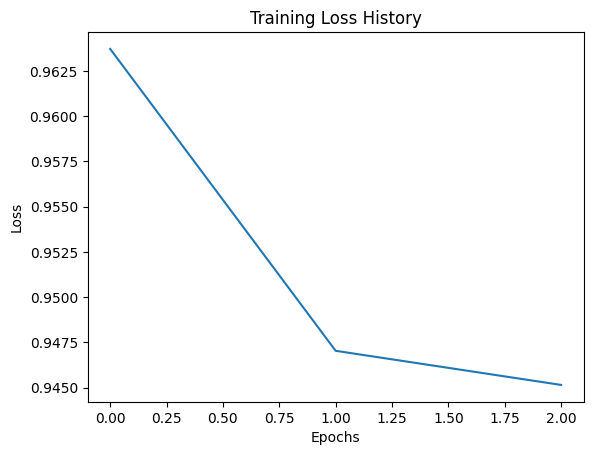

In [2]:
import re
import string
import pandas as pd
import numpy as np
import nltk
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from nltk.tokenize import word_tokenize
from collections import Counter
import spacy
import matplotlib.pyplot as plt

# Download NLTK data
nltk.download('punkt')

# Load spaCy model for entity extraction
nlp = spacy.load('tr_core_news_trf')

# Preprocess text function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[çğışöü]', lambda x: {'ç': 'c', 'ğ': 'g', 'ı': 'i', 'ş': 's', 'ö': 'o', 'ü': 'u'}[x.group()], text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip()
    return text

# Build vocabulary from training texts
def build_vocabulary(texts):
    vocab = Counter()
    for text in texts:
        tokens = word_tokenize(text)
        vocab.update(tokens)
    return vocab

# Tokenize and encode text to sequences
def text_to_sequence(text, word2idx, max_len=512):
    tokens = word_tokenize(text)
    seq = [word2idx.get(token, word2idx["<UNK>"]) for token in tokens]
    if len(seq) < max_len:
        seq += [word2idx["<PAD>"]] * (max_len - len(seq))
    return seq[:max_len]

# Define Transformer block
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, feedforward_dim):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads)
        self.feedforward = nn.Sequential(
            nn.Linear(embed_dim, feedforward_dim),
            nn.ReLU(),
            nn.Linear(feedforward_dim, embed_dim)
        )
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        attn_output, _ = self.attention(x, x, x)
        x = self.layernorm1(x + attn_output)
        feedforward_output = self.feedforward(x)
        x = self.layernorm2(x + feedforward_output)
        return x

# Define BERT-like model
class BERT(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, feedforward_dim, num_layers, max_len):
        super(BERT, self).__init__()
        self.token_embeddings = nn.Embedding(vocab_size, embed_dim)
        self.position_embeddings = nn.Embedding(max_len, embed_dim)
        self.layers = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, feedforward_dim) for _ in range(num_layers)
        ])
        self.fc = nn.Linear(embed_dim, 3)  # For sentiment classification (negative, neutral, positive)

    def forward(self, x):
        seq_len = x.size(1)
        positions = torch.arange(0, seq_len).unsqueeze(0).expand_as(x).to(x.device)
        x = self.token_embeddings(x) + self.position_embeddings(positions)
        for layer in self.layers:
            x = layer(x)
        x = x.mean(dim=1)  # Average pooling
        x = self.fc(x)
        return x

# Training function
def train(model, dataloader, optimizer, device, epochs=3):
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    train_loss_history = []

    for epoch in range(epochs):
        total_loss = 0
        for step, batch in enumerate(dataloader):
            batch_input_ids, batch_labels = batch
            batch_input_ids, batch_labels = batch_input_ids.to(device), batch_labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_input_ids)
            loss = loss_fn(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            if step % 10 == 0:
                print(f"Epoch {epoch}, Step {step}, Loss {loss.item()}")
        
        avg_loss = total_loss / len(dataloader)
        train_loss_history.append(avg_loss)
        print(f"Epoch {epoch} - Average Loss: {avg_loss}")
    
    return train_loss_history

# Evaluation function with additional metrics
def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    true_labels = []
    with torch.no_grad():
        for batch in dataloader:
            batch_input_ids, batch_labels = batch
            batch_input_ids, batch_labels = batch_input_ids.to(device), batch_labels.to(device)
            outputs = model(batch_input_ids)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            true_labels.extend(batch_labels.cpu().numpy())
    
    f1 = f1_score(true_labels, preds, average='weighted')
    accuracy = accuracy_score(true_labels, preds)
    precision = precision_score(true_labels, preds, average='weighted', zero_division=0)
    recall = recall_score(true_labels, preds, average='weighted')
    
    return f1, accuracy, precision, recall

# Print evaluation metrics
def print_evaluation(f1, accuracy, precision, recall):
    print(f"Weighted F1 Score: {f1}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")

# Plot training loss history
def plot_training_history(train_loss_history):
    plt.plot(train_loss_history)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss History')
    plt.show()

# Predict entities and sentiments
def predict_entities_and_sentiments(text, model, word2idx, device):
    model.eval()
    clean_text = preprocess_text(text)
    input_ids = torch.tensor([text_to_sequence(clean_text, word2idx)], dtype=torch.long).to(device)
    with torch.no_grad():
        outputs = model(input_ids)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

    entities = [ent.text for ent in nlp(text).ents]
    sentiments = ["olumsuz" if p == 0 else "nötr" if p == 1 else "olumlu" for p in preds]
    
    result = {
        "entity_list": entities,
        "results": [{"entity": ent, "sentiment": sent} for ent, sent in zip(entities, sentiments)]
    }
    
    return result

# Custom evaluation function
def custom_evaluation(predicted_entities, predicted_sentiments, true_entities, true_sentiments):
    entity_score = 0.65 if set(predicted_entities) == set(true_entities) else 0
    sentiment_score = 0.35 if set(predicted_sentiments) == set(true_sentiments) else 0
    total_score = entity_score + sentiment_score
    return total_score

# Load and preprocess data
def load_and_preprocess_data(filepath):
    data = pd.read_csv(filepath)
    data['clean_text'] = data['text'].apply(preprocess_text)
    return data

# Main function
def main():
    # Load and preprocess data
    data = load_and_preprocess_data('data.csv')

    # Ensure the label column is correct and remap labels to 0, 1, 2 for CrossEntropyLoss
    label_mapping = {-1: 0, 0: 1, 1: 2}
    data['label'] = data['label'].map(label_mapping)

    # Split dataset into training and testing sets
    train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

    # Build vocabulary
    vocab = build_vocabulary(train_data['clean_text'])
    vocab_list = ["<PAD>", "<UNK>"] + [word for word, count in vocab.items() if count > 1]
    word2idx = {word: idx for idx, word in enumerate(vocab_list)}

    # Encode texts to sequences
    train_data['input_ids'] = train_data['clean_text'].apply(lambda x: text_to_sequence(x, word2idx))
    test_data['input_ids'] = test_data['clean_text'].apply(lambda x: text_to_sequence(x, word2idx))

    # Initialize model and set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    vocab_size = len(word2idx)
    embed_dim = 128
    num_heads = 8
    feedforward_dim = 512
    num_layers = 6
    max_len = 512
    model = BERT(vocab_size, embed_dim, num_heads, feedforward_dim, num_layers, max_len).to(device)

    # Convert data to PyTorch tensors
    input_ids = torch.tensor(list(train_data['input_ids']), dtype=torch.long).to(device)
    labels = torch.tensor(list(train_data['label']), dtype=torch.long).to(device)

    # Create DataLoader for training
    train_dataset = TensorDataset(input_ids, labels)
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=8)

    # Initialize optimizer
    optimizer = AdamW(model.parameters(), lr=5e-5)

    # Train model
    train_loss_history = train(model, train_dataloader, optimizer, device)

    # Prepare test data for evaluation
    test_input_ids = torch.tensor(list(test_data['input_ids']), dtype=torch.long).to(device)
    test_labels = torch.tensor(list(test_data['label']), dtype=torch.long).to(device)
    test_dataset = TensorDataset(test_input_ids, test_labels)
    test_sampler = SequentialSampler(test_dataset)
    test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=8)

    # Evaluate model
    f1, accuracy, precision, recall = evaluate(model, test_dataloader, device)
    print_evaluation(f1, accuracy, precision, recall)
    
    # Plot training history
    plot_training_history(train_loss_history)

if __name__ == "__main__":
    main()
